# Log of changes from original calculation

* Urban/rural split is now based on MSASIZE instead of URBRUR variable from NHTS. Now "rural" is outside of any MSA, instead of just not in an urbanized region.
* Added an option to include demand from transit trips in addition to private vehicles and taxis.

# Important things to note:
* This provides the *trip* demand, where a trip is point-to-point travel for one or more members of the same household. So if a family of six all takes the bus, that's *one* trip. This has implications for our assumptions about the sharing factor.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
%matplotlib notebook

## Set up

In [47]:
#Point to a directory containing the NHTS trippub.csv dataset
data_dir = 'C:\\Users\\bgerke.DOMINO0\\Desktop\\NHTS\\'

#Write out somewhere else if desired.
output_dir = data_dir

#Should we include demand from trips on mass transit (public transit, school buses, private shuttles, etc.)?
include_transit = True



In [48]:
#Read in main dataset
trippub_all = pd.read_csv(data_dir+'trippub.csv')
trippub_all.head()
#Trips

,HOUSEID,PERSONID,TDTRPNUM,STRTTIME,ENDTIME,TRVLCMIN,TRPMILES,TRPTRANS,TRPACCMP,TRPHHACC,...,HTRESDN,SMPLSRCE,R_AGE,EDUC,R_SEX,PRMACT,PROXY,WORKER,DRIVER,WTTRDFIN
0,30000007,1,1,1000,1015,15,5.244,3,0,0,...,750,2,67,3,2,6,1,2,1,75441.905796
1,30000007,1,2,1510,1530,20,5.149,3,0,0,...,750,2,67,3,2,6,1,2,1,75441.905796
2,30000007,2,1,700,900,120,84.004,6,0,0,...,750,2,66,3,1,1,2,1,1,71932.645806
3,30000007,2,2,1800,2030,150,81.628,6,0,0,...,750,2,66,3,1,1,2,1,1,71932.645806
4,30000007,3,1,845,900,15,2.250,3,0,0,...,750,2,28,2,2,5,2,2,1,80122.686739


In [49]:
trippub_all.columns.values

array(['HOUSEID', 'PERSONID', 'TDTRPNUM', 'STRTTIME', 'ENDTIME',
       'TRVLCMIN', 'TRPMILES', 'TRPTRANS', 'TRPACCMP', 'TRPHHACC',
       'VEHID', 'TRWAITTM', 'NUMTRANS', 'TRACCTM', 'DROP_PRK', 'TREGRTM',
       'WHODROVE', 'WHYFROM', 'LOOP_TRIP', 'TRPHHVEH', 'HHMEMDRV',
       'HH_ONTD', 'NONHHCNT', 'NUMONTRP', 'PSGR_FLG', 'PUBTRANS',
       'TRIPPURP', 'DWELTIME', 'TDWKND', 'VMT_MILE', 'DRVR_FLG',
       'WHYTRP1S', 'WHYTRP90', 'ONTD_P1', 'ONTD_P2', 'ONTD_P3', 'ONTD_P4',
       'ONTD_P5', 'ONTD_P6', 'ONTD_P7', 'ONTD_P8', 'ONTD_P9', 'ONTD_P10',
       'ONTD_P11', 'ONTD_P12', 'ONTD_P13', 'TDCASEID', 'TRACC_WLK',
       'TRACC_POV', 'TRACC_BUS', 'TRACC_CRL', 'TRACC_SUB', 'TRACC_OTH',
       'TREGR_WLK', 'TREGR_POV', 'TREGR_BUS', 'TREGR_CRL', 'TREGR_SUB',
       'TREGR_OTH', 'WHYTO', 'TRAVDAY', 'HOMEOWN', 'HHSIZE', 'HHVEHCNT',
       'HHFAMINC', 'DRVRCNT', 'HHSTATE', 'HHSTFIPS', 'NUMADLT',
       'WRKCOUNT', 'TDAYDATE', 'HHRESP', 'LIF_CYC', 'MSACAT', 'MSASIZE',
       'RAIL', 'URBAN', '

199097
135705


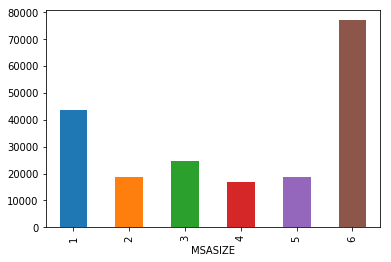

In [33]:
trippub_all.loc[trippub_all['URBRUR']==2].groupby('MSASIZE')['MSASIZE'].count().plot(kind='bar')
#trippub_all['URBRUR'].unique()
print (len(trippub_all.loc[trippub_all['URBRUR']==2]))

print (len(trippub_all.loc[trippub_all['MSASIZE']==6]))

In [40]:
include_transit = True

#Personal motor vehicle codes from code book
#This is car, suv, van, pickup truck,  motorcycle, RV, rental car
#LEAVES OUT 17-taxis/TNCs, because (I believe) we cannot weight these correctly since must weight by driver. 

pmvcodes = [3,4,5,6,8,9,18]
selection = (trippub_all['TRPTRANS'].isin(pmvcodes)) & (trippub_all['DRVR_FLG']==1)

if include_transit:
    #Transit vehicle codes from code book are 10-17 (including taxis/TNCs)
    trnstcodes = list(range(10,18))
    #Now our selected trips are the selection above OR any public transit
    selection |= trippub_all['TRPTRANS'].isin(trnstcodes)

trippub = trippub_all.loc[selection]
print(trippub['TRPTRANS'].count())
print(trippub['WTTRDFIN'].sum())


638883
240036829896.23468


In [12]:
taxitrips = trippub_all.loc[trippub_all['TRPTRANS']==17].groupby(['HOUSEID','TDAYDATE','STRTTIME']).first()
#The above cuts out duplicate trips, where two people in the same household reported the same taxi trip. Serves
#a similar purpose to restricting by driver flag
trippub = trippub.append(taxitrips)
trippub.reset_index(drop=True, inplace=True)
print(taxitrips['TRPTRANS'].count())
print(taxitrips['WTTRDFIN'].sum())
#Surprisingly few taxi trips...

2394
1615969202.34


In [46]:
print(len(trippub_all.loc[trippub_all['TRPTRANS'].isin(trnstcodes)]))
print(len(trippub_all.loc[trippub_all['TRPTRANS'].isin(trnstcodes)].groupby(['HOUSEID','TDAYDATE','STRTTIME']).first()))

27541
24277


In [10]:
#Avg mileages
print(trippub['TRPMILES'].mul(trippub['WTTRDFIN']).sum()/trippub['WTTRDFIN'].sum())
print(taxitrips['TRPMILES'].mul(taxitrips['WTTRDFIN']).sum()/taxitrips['WTTRDFIN'].sum())

9.54319394103
8.22285875211


In [13]:
trippub.tail()

,CDIVMSAR,CENSUS_D,CENSUS_R,DRIVER,DROP_PRK,DRVRCNT,DRVR_FLG,DWELTIME,EDUC,ENDTIME,...,VEHID,VMT_MILE,WHODROVE,WHYFROM,WHYTO,WHYTRP1S,WHYTRP90,WORKER,WRKCOUNT,WTTRDFIN
613731,91,9,4,1,-1,2,-1,108,4,932,...,-1,-1.0,-1,1,3,10,1,1,2,344957.415508
613732,91,9,4,1,-1,2,-1,65,4,1135,...,-1,-1.0,-1,3,1,1,1,1,2,344957.415508
613733,91,9,4,1,-1,2,-1,-9,4,2025,...,-1,-1.0,-1,7,1,1,10,1,2,408975.662752
613734,91,9,4,1,-1,2,-1,40,4,1200,...,-1,-1.0,-1,2,1,1,11,1,2,422950.854805
613735,91,9,4,1,-1,2,-1,-9,4,1300,...,-1,-1.0,-1,1,2,1,11,1,2,422950.854805


In [22]:
#Trim out long road trips
trippub = trippub.loc[trippub['TRPMILES'] < 300]
print(len(trippub))
print(trippub['WTTRDFIN'].sum())

print(trippub['TRPMILES'].mul(trippub['WTTRDFIN']).sum()/trippub['WTTRDFIN'].sum())

613205
2.21835869978e+11
8.90120102813


In [15]:
#Create Census Division/ Large State category with urban/rural split.
#Also Census region urban/rural split

cdiv = {1:'NENG', 2:'MAT', 3:'ENC', 4:'WNC', 5:'SAT', 6:'ESC', 7:'WSC', 8:'MTN', 9:'PAC'}
creg = {1:'NEAST', 2:'MIDW', 3:'SOUTH', 4:'WEST'}
for k in cdiv.keys():
    trippub.loc[trippub['CENSUS_D']==k, 'CDIVLS'] = cdiv[k]
for k in creg.keys():
    trippub.loc[trippub['CENSUS_R']==k, 'REGION'] = creg[k]

lgst = ['CA', 'NY','FL','TX']

for s in lgst:
    div = cdiv[trippub.loc[trippub['HHSTATE']==s, 'CENSUS_D'].unique()[0]]
    #print reg
    trippub.loc[(trippub['HHSTATE']==s), 'CDIVLS'] = div+'-'+s
    trippub.loc[(trippub['CDIVLS']==div) & (trippub['HHSTATE']!=s), 'CDIVLS'] = div+'-NL' 
    

#Turn urban/rural codes into strings    
trippub['URBRURS'] = 'RUR'
#trippub.loc[trippub['URBRUR'] == 1, 'URBRURS'] = 'URB'
#Instead of the above, divide urban vs rural according to metropolitan statistical area size: all MSAs are urban
trippub.loc[trippub['MSASIZE']<6,'URBRURS'] == 'URB'

#Turn weekday/weekend into clearer coding
trippub['WKTIME'] = 'WEEKDAY'
trippub.loc[trippub['TDWKND']==1, 'WKTIME'] = 'WEEKEND'

print trippub['CDIVLS'].unique()
print trippub['REGION'].unique()

['SAT-NL' 'ENC' 'MAT-NY' 'MAT-NL' 'PAC-CA' 'WSC-TX' 'PAC-NL' 'ESC' 'MTN'
 'WNC' 'NENG' 'SAT-FL' 'WSC-NL']
['SOUTH' 'MIDW' 'NEAST' 'WEST']


In [16]:
#Set mileage bin edges
mibins=[0,2,5,10,20,30,50,100,300]
mibin_labels=pd.Series(mibins[:-1]).astype(str).str.cat(pd.Series(mibins[1:]).astype(str), sep='-')

In [17]:
#Categorize trips by mileage

trippub['MILEBIN'] = pd.cut(trippub['TRPMILES'], mibins, labels=mibin_labels)


In [18]:
#Compute distance histograms (and average distances) by CDLS

dist_hists = trippub.groupby(['CDIVLS', 'URBRURS',
                              'WKTIME','MILEBIN']).agg({'WTTRDFIN':[len, np.sum], 
                                                               'TRPMILES':np.mean,
                                                               'REGION':'first'}
                                                       ).rename(columns=
                                                                {'mean':'AVGDIST',
                                                                 'first':'REGION', 
                                                                 'len':'COUNTSRAW',
                                                                 'sum':'COUNTSWTD'}, level=1)

dist_hists.columns = dist_hists.columns.droplevel(0)
dist_hists

#NOTE: COUNTSWTD here represents the total ANNNUAL number of trips in each bin.

AVGDIST REGION  COUNTSRAW     COUNTSWTD
CDIVLS URBRURS WKTIME  MILEBIN                                            
ENC    RUR     WEEKDAY 0-2        0.925071   MIDW     4023.0  1.138172e+09
                       2-5        3.410025   MIDW     3513.0  1.206380e+09
                       5-10       7.251388   MIDW     3814.0  1.175054e+09
                       10-20     14.339980   MIDW     3429.0  1.189582e+09
                       20-30     24.135832   MIDW     1298.0  4.191658e+08
                       30-50     37.854290   MIDW      824.0  2.749884e+08
                       50-100    67.220655   MIDW      362.0  1.076247e+08
                       100-300  156.941638   MIDW      138.0  4.117412e+07
               WEEKEND 0-2        0.943834   MIDW      729.0  3.251322e+08
                       2-5        3.413881   MIDW      756.0  4.178769e+08
                       5-10       7.145351   MIDW      738.0  4.177582e+08
                       10-20     13.862837   MIDW      669.0  3.688652e+08
                       20-30     24.500347   MIDW      225.0  1.431343e+08
                       30-50     38.629740   MIDW      131.0  8.871814e+07
                       50-100    69.354357   MIDW      112.0  3.781140e+07
                       100-300  155.181304   MIDW       46.0  2.426563e+07
       URB     WEEKDAY 0-2        1.089107   MIDW    14092.0  5.963336e+09
                       2-5        3.251441   MIDW    13121.0  5.676272e+09
                       5-10       7.091082   MIDW     7564.0  3.573772e+09
                       10-20     13.994260   MIDW     5399.0  2.630689e+09
                       20-30     24.161824   MIDW     1730.0  8.911034e+08
                       30-50     37.706127   MIDW     1155.0  5.650265e+08
                       50-100    68.944939   MIDW      489.0  1.554142e+08
                       100-300  152.439716   MIDW      232.0  7.015612e+07
               WEEKEND 0-2        1.105384   MIDW     3085.0  2.327699e+09
                       2-5        3.247420   MIDW     2834.0  2.311740e+09
                       5-10       7.114083   MIDW     1533.0  1.144392e+09
                       10-20     14.040648   MIDW      961.0  7.261565e+08
                       20-30     24.009827   MIDW      336.0  2.705310e+08
                       30-50     38.643021   MIDW      233.0  1.581827e+08
...                                    ...    ...        ...           ...
WSC-TX RUR     WEEKDAY 5-10       7.259811  SOUTH     3111.0  3.928130e+08
                       10-20     14.086265  SOUTH     3111.0  3.975459e+08
                       20-30     24.385820  SOUTH     1265.0  1.607947e+08
                       30-50     38.119035  SOUTH      925.0  1.253258e+08
                       50-100    65.689383  SOUTH      355.0  4.863727e+07
                       100-300  171.684050  SOUTH      140.0  1.705005e+07
               WEEKEND 0-2        0.970121  SOUTH      521.0  1.516085e+08
                       2-5        3.462924  SOUTH      524.0  1.377147e+08
                       5-10       7.290619  SOUTH      620.0  1.655277e+08
                       10-20     14.113361  SOUTH      554.0  1.634919e+08
                       20-30     24.285534  SOUTH      191.0  5.212207e+07
                       30-50     37.718971  SOUTH      138.0  3.896700e+07
                       50-100    64.597105  SOUTH       57.0  1.773670e+07
                       100-300  180.607925  SOUTH       40.0  1.325192e+07
       URB     WEEKDAY 0-2        1.117194  SOUTH    25535.0  3.461134e+09
                       2-5        3.278373  SOUTH    26132.0  3.397813e+09
                       5-10       7.108631  SOUTH    16284.0  2.170669e+09
                       10-20     14.199380  SOUTH    12587.0  1.711586e+09
                       20-30     24.168030  SOUTH     4681.0  6.264027e+08
                       30-50     36.866127  SOUTH     2234.0  2.914200e+08
                       50-100    68.191115  SOUTH      766.0

In [23]:
#Check avg mileages
print(dist_hists['AVGDIST'].mul(dist_hists['COUNTSWTD']).sum()/dist_hists['COUNTSWTD'].sum())

8.90052138782


In [25]:
trippub['STRTHOUR'] = pd.cut(trippub['STRTTIME'], np.arange(25)*100, labels=np.arange(24))

In [26]:
#Compute hourly trip volume profiles by region and urb/rural

hourly_profiles = trippub.groupby(['REGION', 
                                   'URBRURS', 
                                   'WKTIME', 
                                   'MILEBIN',
                                   'STRTHOUR'])['WTTRDFIN'].agg([len, 
                                                                 np.sum]).rename(columns=
                                                                                 {'len':'COUNTSRAW',
                                                                                  'sum':'COUNTSWTD'})
#NOTE: COUNTSWTD here represents the total ANNNUAL number of trips in each bin.

In [27]:
hourly_profiles

COUNTSRAW     COUNTSWTD
REGION URBRURS WKTIME  MILEBIN STRTHOUR                         
MIDW   RUR     WEEKDAY 0-2     0               3.0  2.672080e+06
                               2               1.0  1.688021e+05
                               3               1.0  4.899141e+06
                               4              14.0  9.166322e+06
                               5              60.0  1.327238e+07
                               6             107.0  4.492360e+07
                               7             334.0  1.648905e+08
                               8             291.0  1.323389e+08
                               9             369.0  1.245468e+08
                               10            472.0  1.618731e+08
                               11            559.0  2.362179e+08
                               12            505.0  1.866245e+08
                               13            446.0  1.573448e+08
                               14            315.0  1.004938e+08
                               15            423.0  1.636145e+08
                               16            404.0  1.804065e+08
                               17            288.0  1.063271e+08
                               18            155.0  1.190477e+08
                               19             93.0  5.593942e+07
                               20             61.0  4.606398e+07
                               21             36.0  1.576720e+07
                               22             20.0  1.134263e+07
                               23              5.0  1.440192e+06
                       2-5     0               3.0  2.485870e+05
                               2               3.0  1.601314e+06
                               3               3.0  9.803437e+05
                               4              36.0  9.627509e+06
                               5              62.0  8.976141e+06
                               6             137.0  4.494250e+07
                               7             328.0  1.550675e+08
...                                            ...           ...
WEST   URB     WEEKEND 50-100  15             43.0  1.395163e+07
                               16             49.0  1.601509e+07
                               17             41.0  1.846462e+07
                               18             38.0  1.387281e+07
                               19             28.0  1.376506e+07
                               20             27.0  7.552995e+06
                               21             16.0  3.587906e+06
                               22             11.0  6.029520e+06
                               23              2.0  8.382548e+05
                       100-300 0               3.0  6.107568e+05
                               3               2.0  1.780639e+05
                               4               5.0  7.085884e+05
                               5               8.0  3.073065e+06
                               6              14.0  5.788551e+06
                               7              19.0  2.315651e+06
                               8              28.0  1.011238e+07
                               9              21.0  5.212559e+06
                               10             22.0  5.455981e+06
                               11             29.0  8.011108e+06
                               12             20.0  4.033717e+06
                               13             22.0  6.232639e+06
                               14             22.0  4.162898e+06
                               15             27.0  1.019717e+07
                               16             17.0  2.468293e+06
                               17             19.0  4.109369e+06
                               18             22.0  8.234929e+06
                               19             12.0  3.470126e+06
                               20             15.0  6.764645e+06
                               21              5.0  1.217245e+06
           

In [28]:
hourly_profiles['TRIPPCT'] = 0
for row in [(a,b,c,d) 
            for a in hourly_profiles.index.levels[0].unique() 
            for b in hourly_profiles.index.levels[1].unique() 
            for c in hourly_profiles.index.levels[2].unique() 
            for d in hourly_profiles.index.levels[3].unique()]:
    pct=hourly_profiles.loc[row,'COUNTSWTD']/(hourly_profiles.loc[row,'COUNTSWTD'].sum(skipna=True)+1.e-10)
    for h in pct.index.values: 
        hourly_profiles.loc[row+(h,), 'TRIPPCT'] = pct[h]

In [29]:
hourly_profiles.unstack('STRTHOUR', fill_value=0)['TRIPPCT'].T

REGION        MIDW                                                    \
URBRURS        RUR                                                     
WKTIME     WEEKDAY                                                     
MILEBIN        0-2       2-5      5-10     10-20     20-30     30-50   
STRTHOUR                                                               
0         0.001310  0.000153  0.001313  0.006490  0.018461  0.000654   
1         0.000000  0.000000  0.003656  0.000103  0.001771  0.000495   
2         0.000083  0.000983  0.000065  0.000446  0.000031  0.000000   
3         0.002402  0.000602  0.000127  0.002208  0.002740  0.009953   
4         0.004495  0.005910  0.003477  0.013346  0.020605  0.032882   
5         0.006508  0.005510  0.014398  0.043099  0.048041  0.051957   
6         0.022028  0.027587  0.041185  0.074463  0.098460  0.122158   
7         0.080853  0.095184  0.099573  0.111631  0.094978  0.078927   
8         0.064892  0.044832  0.070865  0.058165  0.043756  0.062995   
9         0.061071  0.066176  0.080183  0.034915  0.062784  0.079584   
10        0.079374  0.058663  0.054719  0.055856  0.046677  0.023009   
11        0.115828  0.063167  0.066832  0.055689  0.042067  0.045301   
12        0.091510  0.063773  0.063739  0.048345  0.046870  0.024096   
13        0.077153  0.056776  0.064031  0.044603  0.048119  0.057970   
14        0.049277  0.085610  0.058748  0.076874  0.045348  0.051589   
15        0.080227  0.105122  0.083155  0.100353  0.104452  0.097878   
16        0.088461  0.086181  0.100717  0.093868  0.103656  0.122902   
17        0.052137  0.093339  0.075097  0.092058  0.091109  0.048698   
18        0.058374  0.071457  0.048618  0.027087  0.022205  0.016150   
19        0.027430  0.029200  0.027321  0.018824  0.016937  0.023047   
20        0.022587  0.015602  0.014600  0.014980  0.013217  0.014760   
21        0.007731  0.010519  0.024673  0.011290  0.002949  0.018263   
22        0.005562  0.008739  0.002727  0.012827  0.008099  0.016464   
23        0.000706  0.004918  0.000181  0.002479  0.016670  0.000269   

REGION                                              ...         WEST  \
URBRURS                                             ...          URB   
WKTIME                         WEEKEND              ...      WEEKDAY   
MILEBIN     50-100   100-300       0-2       2-5    ...       50-100   
STRTHOUR                                            ...                
0         0.000000  0.000000  0.000000  0.009491    ...     0.005459   
1         0.000373  0.000000  0.000059  0.004437    ...     0.004833   
2         0.003900  0.000000  0.000000  0.000000    ...     0.002312   
3         0.000564  0.001545  0.000000  0.005229    ...     0.001904   
4         0.020813  0.040914  0.000398  0.007057    ...     0.067470   
5         0.033002  0.051264  0.015155  0.007639    ...     0.056557   
6         0.060840  0.076325  0.009627  0.022394    ...     0.054031   
7         0.039542  0.067592  0.017881  0.049037    ...     0.068316   
8         0.070689  0.091996  0.054485  0.072643    ...     0.043405   
9         0.058216  0.125587  0.104206  0.067250    ...     0.047142   
10        0.050132  0.021294  0.095283  0.078867    ...     0.065999   
11        0.127620  0.052812  0.116413  0.085930    ...     0.044675   
12        0.066270  0.059644  0.101797  0.053777    ...     0.048835   
13        0.054213  0.081384  0.074788  0.067314    ...     0.110892   
14        0.038777  0.041301  0.090524  0.062251    ...     0.057166   
15        0.091234  0.088456  0.053587  0.068292    ...     0.088102   
16        0.140553  0.014331  0.035859  0.071390    ...     0.108097   
17        0.058256  0.147202  0.046203  0.064850    ...     0.032105   
18        0.035325  0.036689  0.072278  0.035487    ...     0.042292   
19        0.029042  0.001663  0.068781  0.061447    ...     0.015600   
20        0.000475  0.000000  0.019512  0.032325    ...     0.014918   
21        0.000774  0.000000  0.015424 

In [30]:
hourly_profiles_agg = trippub.groupby(['URBRURS', 
                                   'WKTIME', 
                                   'MILEBIN',
                                   'STRTHOUR'])['WTTRDFIN'].agg([len, 
                                                                 np.sum]).rename(columns=
                                                                                 {'len':'COUNTSRAW',
                                                                                  'sum':'COUNTSWTD'})

In [31]:
hourly_profiles_agg['TRIPPCT'] = 0
for row in [(a,b,c) 
            for a in hourly_profiles_agg.index.levels[0].unique() 
            for b in hourly_profiles_agg.index.levels[1].unique() 
            for c in hourly_profiles_agg.index.levels[2].unique()]:
    pct=hourly_profiles_agg.loc[row,'COUNTSWTD']/(hourly_profiles_agg.loc[row,'COUNTSWTD'].sum(skipna=True)+1.e-10)
    for h in pct.index.values: 
        hourly_profiles_agg.loc[row+(h,), 'TRIPPCT'] = pct[h]

In [32]:
hourly_profiles_agg

COUNTSRAW     COUNTSWTD   TRIPPCT
URBRURS WKTIME  MILEBIN STRTHOUR                                   
RUR     WEEKDAY 0-2     0               9.0  3.820271e+06  0.000624
                        1               1.0  2.720234e+04  0.000004
                        2               1.0  1.688021e+05  0.000028
                        3               3.0  4.933251e+06  0.000806
                        4              42.0  1.308867e+07  0.002138
                        5             184.0  5.076653e+07  0.008293
                        6             463.0  1.602533e+08  0.026179
                        7            1335.0  3.988634e+08  0.065157
                        8            1319.0  3.687985e+08  0.060246
                        9            1747.0  3.817226e+08  0.062357
                        10           2208.0  4.358206e+08  0.071195
                        11           2753.0  6.135356e+08  0.100226
                        12           2778.0  6.877927e+08  0.112356
                        13           2257.0  5.024851e+08  0.082085
                        14           2035.0  4.112836e+08  0.067186
                        15           2133.0  5.385738e+08  0.087980
                        16           1879.0  5.439644e+08  0.088861
                        17           1420.0  3.774200e+08  0.061655
                        18            786.0  2.706120e+08  0.044207
                        19            498.0  1.591644e+08  0.026001
                        20            332.0  1.178097e+08  0.019245
                        21            148.0  4.629810e+07  0.007563
                        22             62.0  2.216596e+07  0.003621
                        23             28.0  1.216335e+07  0.001987
                2-5     0              16.0  3.532641e+06  0.000589
                        1               7.0  5.388954e+06  0.000898
                        2               6.0  3.149173e+06  0.000525
                        3               7.0  1.427172e+06  0.000238
                        4              94.0  2.015450e+07  0.003358
                        5             250.0  4.885402e+07  0.008139
...                                     ...           ...       ...
URB     WEEKEND 50-100  17            110.0  6.286995e+07  0.079040
                        18            132.0  6.142208e+07  0.077220
                        19             99.0  4.602674e+07  0.057865
                        20             81.0  3.104815e+07  0.039034
                        21             56.0  1.984498e+07  0.024949
                        22             34.0  1.190867e+07  0.014972
                        23             11.0  4.015252e+06  0.005048
                100-300 0               6.0  1.788979e+06  0.003762
                        1               1.0  8.406507e+05  0.001768
                        3               4.0  2.322385e+06  0.004884
                        4              15.0  6.295021e+06  0.013239
                        5              21.0  1.325542e+07  0.027878
                        6              31.0  1.642368e+07  0.034541
                        7              60.0  3.817921e+07  0.080296
                        8              77.0  2.411937e+07  0.050726
                        9              79.0  2.916234e+07  0.061332
                        10             78.0  5.058215e+07  0.106381
                        11             81.0  3.316134e+07  0.069743
                        12             58.0  2.329421e+07  0.048991
                        13             81.0  3.585036e+07  0.075398
                        14             67.0  2.224357e+07  0.046781
                        15             75.0  3.922222e+07  0.082490
                        16             63.0  2.024485e+07  0.042578
                        17             61.0  2.963891e+07  0.062335
                        18             73.0  3.299337e+07  0.069390
                        19             44.0  3.023079e+07  0.063579
                      

<IPython.core.display.Javascript object>


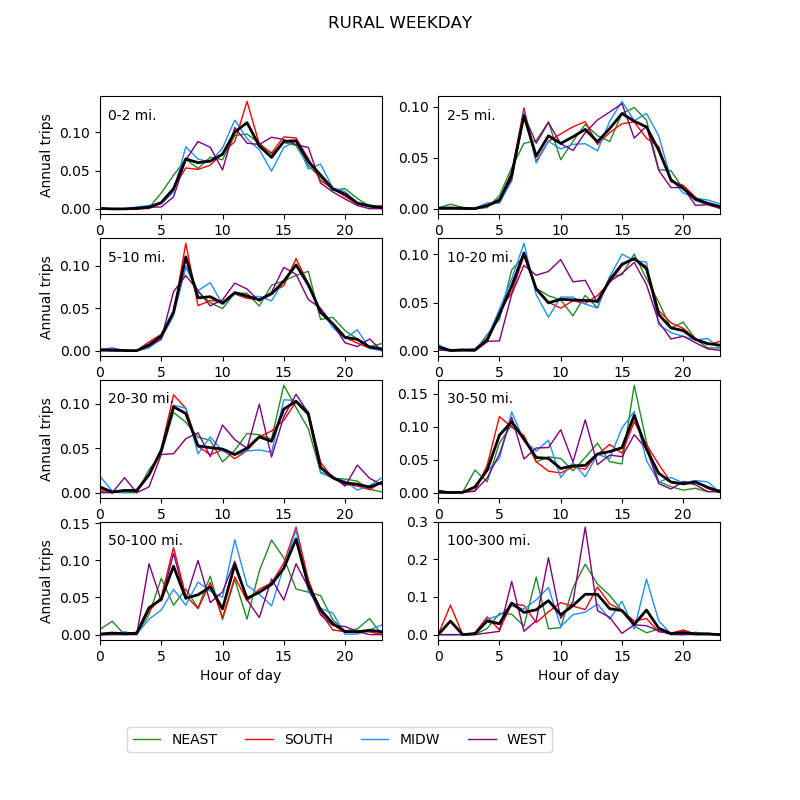

('NEAST', 'RUR', 'WEEKDAY')
('SOUTH', 'RUR', 'WEEKDAY')
('MIDW', 'RUR', 'WEEKDAY')
('WEST', 'RUR', 'WEEKDAY')


In [33]:
def plot_dists_by_region(plotdata, regions=['NEAST','SOUTH','MIDW','WEST'], urbrur='URB', wktime='WEEKDAY',
                         alldata = None,
                         colors=None):
    fig = plt.figure()
    gs = gridspec.GridSpec(nrows=4, ncols=2, bottom=0.2)

    for i in range(len(mibins[:-1])):
        fig.add_subplot(gs[i/2, i%2])

    axs = fig.axes
    
    if not colors:
        colors=['forestgreen','red','dodgerblue','purple']

    #plotdata = dists.unstack('STRTHOUR', fill_value=0)['TRIPPCT'].T
    for i, reg in enumerate(regions):
        sel=(reg,urbrur,wktime)
        print sel
        #plotdata = dists.loc[sel].unstack('STRTHOUR', fill_value=0)['TRIPPCT'].T
        #plotdata.index = np.arange(24)
        plotdata[sel].plot(subplots=True, legend=None, color=colors[i], ax=axs, linewidth=1)

    if alldata is not None:
        alldata[(urbrur,wktime)].plot(subplots=True, legend=None,color='k', ax=axs, linewidth=2)
    for i, ax in enumerate(axs):
        col = plotdata[sel].columns[i]
        miles = col.split('-')
        ax.annotate(str(miles[0])+'-'+str(miles[1])+' mi.', [0.03,0.8], xycoords='axes fraction')
        if i > 5:
            ax.set_xlabel('Hour of day')
            
        if i % 2 == 0:
            ax.set_ylabel('Annual trips')

    plt.legend(ax.lines, regions,ncol=4, loc=2, bbox_to_anchor=(0.15,0.1), bbox_transform=fig.transFigure)
    
    if urbrur == 'URB': 
        urname='URBAN' 
    else: 
        urname='RURAL'
    fig.suptitle(urname+' '+wktime)
    
plt.rcParams['figure.figsize'] = [8, 8]    
plotdata = hourly_profiles.unstack('STRTHOUR', fill_value=0)['TRIPPCT'].T
alldata = hourly_profiles_agg.unstack('STRTHOUR', fill_value=0)['TRIPPCT'].T
plot_dists_by_region(plotdata, urbrur='RUR', wktime='WEEKDAY', alldata=alldata)

In [35]:
dist_hour_hists = dist_hists.copy()
dist_hour_hists.rename(columns={'COUNTSRAW':'NRAW', 'COUNTSWTD':'NWTD'},inplace=True)
dist_hour_hists

AVGDIST REGION     NRAW          NWTD
CDIVLS URBRURS WKTIME  MILEBIN                                          
ENC    RUR     WEEKDAY 0-2        0.925071   MIDW   4023.0  1.138172e+09
                       2-5        3.410025   MIDW   3513.0  1.206380e+09
                       5-10       7.251388   MIDW   3814.0  1.175054e+09
                       10-20     14.339980   MIDW   3429.0  1.189582e+09
                       20-30     24.135832   MIDW   1298.0  4.191658e+08
                       30-50     37.854290   MIDW    824.0  2.749884e+08
                       50-100    67.220655   MIDW    362.0  1.076247e+08
                       100-300  156.941638   MIDW    138.0  4.117412e+07
               WEEKEND 0-2        0.943834   MIDW    729.0  3.251322e+08
                       2-5        3.413881   MIDW    756.0  4.178769e+08
                       5-10       7.145351   MIDW    738.0  4.177582e+08
                       10-20     13.862837   MIDW    669.0  3.688652e+08
                       20-30     24.500347   MIDW    225.0  1.431343e+08
                       30-50     38.629740   MIDW    131.0  8.871814e+07
                       50-100    69.354357   MIDW    112.0  3.781140e+07
                       100-300  155.181304   MIDW     46.0  2.426563e+07
       URB     WEEKDAY 0-2        1.089107   MIDW  14092.0  5.963336e+09
                       2-5        3.251441   MIDW  13121.0  5.676272e+09
                       5-10       7.091082   MIDW   7564.0  3.573772e+09
                       10-20     13.994260   MIDW   5399.0  2.630689e+09
                       20-30     24.161824   MIDW   1730.0  8.911034e+08
                       30-50     37.706127   MIDW   1155.0  5.650265e+08
                       50-100    68.944939   MIDW    489.0  1.554142e+08
                       100-300  152.439716   MIDW    232.0  7.015612e+07
               WEEKEND 0-2        1.105384   MIDW   3085.0  2.327699e+09
                       2-5        3.247420   MIDW   2834.0  2.311740e+09
                       5-10       7.114083   MIDW   1533.0  1.144392e+09
                       10-20     14.040648   MIDW    961.0  7.261565e+08
                       20-30     24.009827   MIDW    336.0  2.705310e+08
                       30-50     38.643021   MIDW    233.0  1.581827e+08
...                                    ...    ...      ...           ...
WSC-TX RUR     WEEKDAY 5-10       7.259811  SOUTH   3111.0  3.928130e+08
                       10-20     14.086265  SOUTH   3111.0  3.975459e+08
                       20-30     24.385820  SOUTH   1265.0  1.607947e+08
                       30-50     38.119035  SOUTH    925.0  1.253258e+08
                       50-100    65.689383  SOUTH    355.0  4.863727e+07
                       100-300  171.684050  SOUTH    140.0  1.705005e+07
               WEEKEND 0-2        0.970121  SOUTH    521.0  1.516085e+08
                       2-5        3.462924  SOUTH    524.0  1.377147e+08
                       5-10       7.290619  SOUTH    620.0  1.655277e+08
                       10-20     14.113361  SOUTH    554.0  1.634919e+08
                       20-30     24.285534  SOUTH    191.0  5.212207e+07
                       30-50     37.718971  SOUTH    138.0  3.896700e+07
                       50-100    64.597105  SOUTH     57.0  1.773670e+07
                       100-300  180.607925  SOUTH     40.0  1.325192e+07
       URB     WEEKDAY 0-2        1.117194  SOUTH  25535.0  3.461134e+09
                       2-5        3.278373  SOUTH  26132.0  3.397813e+09
                       5-10       7.108631  SOUTH  16284.0  2.170669e+09
                       10-20     14.199380  SOUTH  12587.0  1.711586e+09
                       20-30     24.168030  SOUTH   4681.0  6.264027e+08
                       30-50     36.866127  SOUTH   2234.0  2.914200e+08
                       50-100    68.191115  SOUTH    766.0  9.863122e+07
                       100-300  169.951510  SOUTH    494.0  6.658455e+07
               WEEKE

In [36]:
hcols=[]
for h in range(24):
    col='NWTD_'+format(h,'02d')
    hcols.append(col)
    dist_hour_hists[h]=0
    
dist_hour_hists

AVGDIST REGION     NRAW          NWTD  0  \
CDIVLS URBRURS WKTIME  MILEBIN                                                
ENC    RUR     WEEKDAY 0-2        0.925071   MIDW   4023.0  1.138172e+09  0   
                       2-5        3.410025   MIDW   3513.0  1.206380e+09  0   
                       5-10       7.251388   MIDW   3814.0  1.175054e+09  0   
                       10-20     14.339980   MIDW   3429.0  1.189582e+09  0   
                       20-30     24.135832   MIDW   1298.0  4.191658e+08  0   
                       30-50     37.854290   MIDW    824.0  2.749884e+08  0   
                       50-100    67.220655   MIDW    362.0  1.076247e+08  0   
                       100-300  156.941638   MIDW    138.0  4.117412e+07  0   
               WEEKEND 0-2        0.943834   MIDW    729.0  3.251322e+08  0   
                       2-5        3.413881   MIDW    756.0  4.178769e+08  0   
                       5-10       7.145351   MIDW    738.0  4.177582e+08  0   
                       10-20     13.862837   MIDW    669.0  3.688652e+08  0   
                       20-30     24.500347   MIDW    225.0  1.431343e+08  0   
                       30-50     38.629740   MIDW    131.0  8.871814e+07  0   
                       50-100    69.354357   MIDW    112.0  3.781140e+07  0   
                       100-300  155.181304   MIDW     46.0  2.426563e+07  0   
       URB     WEEKDAY 0-2        1.089107   MIDW  14092.0  5.963336e+09  0   
                       2-5        3.251441   MIDW  13121.0  5.676272e+09  0   
                       5-10       7.091082   MIDW   7564.0  3.573772e+09  0   
                       10-20     13.994260   MIDW   5399.0  2.630689e+09  0   
                       20-30     24.161824   MIDW   1730.0  8.911034e+08  0   
                       30-50     37.706127   MIDW   1155.0  5.650265e+08  0   
                       50-100    68.944939   MIDW    489.0  1.554142e+08  0   
                       100-300  152.439716   MIDW    232.0  7.015612e+07  0   
               WEEKEND 0-2        1.105384   MIDW   3085.0  2.327699e+09  0   
                       2-5        3.247420   MIDW   2834.0  2.311740e+09  0   
                       5-10       7.114083   MIDW   1533.0  1.144392e+09  0   
                       10-20     14.040648   MIDW    961.0  7.261565e+08  0   
                       20-30     24.009827   MIDW    336.0  2.705310e+08  0   
                       30-50     38.643021   MIDW    233.0  1.581827e+08  0   
...                                    ...    ...      ...           ... ..   
WSC-TX RUR     WEEKDAY 5-10       7.259811  SOUTH   3111.0  3.928130e+08  0   
                       10-20     14.086265  SOUTH   3111.0  3.975459e+08  0   
                       20-30     24.385820  SOUTH   1265.0  1.607947e+08  0   
                       30-50     38.119035  SOUTH    925.0  1.253258e+08  0   
                       50-100    65.689383  SOUTH    355.0  4.863727e+07  0   
                       100-300  171.684050  SOUTH    140.0  1.705005e+07  0   
               WEEKEND 0-2        0.970121  SOUTH    521.0  1.516085e+08  0   
                       2-5        3.462924  SOUTH    524.0  1.377147e+08  0   
                       5-10       7.290619  SOUTH    620.0  1.655277e+08  0   
                       10-20     14.113361  SOUTH    554.0  1.634919e+08  0   
                       20-30     24.285534  SOUTH    191.0  5.212207e+07  0   
                       30-50     37.718971  SOUTH    138.0  3.896700e+07  0   
                       50-100    64.597105  SOUTH     57.0  1.773670e+07  0   
                       100-300  180.607925  SOUTH     40.0  1.325192e+07  0   
       URB     WEEKDAY 0-2        1.117194  SOUTH  25535.0  3.461134e+09  0   
                       2-5        3.278373  SOUTH  26132.0  3.397813e+09  0   
                       5-10       7.108631  SOUTH  16284.0  2.170669e+09  0   
                       10-20     14.199380  SOUTH  12587.0  1.711586e+09  0   
      

In [37]:
for reg in dist_hists.index.levels[0]:
    print reg
    dist_hour_hists.loc[reg,range(24)] = \
        hourly_profiles_agg['TRIPPCT'].unstack('STRTHOUR').T.mul(\
                                            dist_hists.loc[reg,'COUNTSWTD']).fillna(0.).T.values

dist_hour_hists
#hourly_profiles_agg['TRIPPCT'].unstack('STRTHOUR').T.mul(dist_hists.loc[reg,'COUNTSWTD']).fillna(0.).T

ENC
ESC
MAT-NL
MAT-NY
MTN
NENG
PAC-CA
PAC-NL
SAT-FL
SAT-NL
WNC
WSC-NL
WSC-TX


AVGDIST REGION     NRAW          NWTD  \
CDIVLS URBRURS WKTIME  MILEBIN                                             
ENC    RUR     WEEKDAY 0-2        0.925071   MIDW   4023.0  1.138172e+09   
                       2-5        3.410025   MIDW   3513.0  1.206380e+09   
                       5-10       7.251388   MIDW   3814.0  1.175054e+09   
                       10-20     14.339980   MIDW   3429.0  1.189582e+09   
                       20-30     24.135832   MIDW   1298.0  4.191658e+08   
                       30-50     37.854290   MIDW    824.0  2.749884e+08   
                       50-100    67.220655   MIDW    362.0  1.076247e+08   
                       100-300  156.941638   MIDW    138.0  4.117412e+07   
               WEEKEND 0-2        0.943834   MIDW    729.0  3.251322e+08   
                       2-5        3.413881   MIDW    756.0  4.178769e+08   
                       5-10       7.145351   MIDW    738.0  4.177582e+08   
                       10-20     13.862837   MIDW    669.0  3.688652e+08   
                       20-30     24.500347   MIDW    225.0  1.431343e+08   
                       30-50     38.629740   MIDW    131.0  8.871814e+07   
                       50-100    69.354357   MIDW    112.0  3.781140e+07   
                       100-300  155.181304   MIDW     46.0  2.426563e+07   
       URB     WEEKDAY 0-2        1.089107   MIDW  14092.0  5.963336e+09   
                       2-5        3.251441   MIDW  13121.0  5.676272e+09   
                       5-10       7.091082   MIDW   7564.0  3.573772e+09   
                       10-20     13.994260   MIDW   5399.0  2.630689e+09   
                       20-30     24.161824   MIDW   1730.0  8.911034e+08   
                       30-50     37.706127   MIDW   1155.0  5.650265e+08   
                       50-100    68.944939   MIDW    489.0  1.554142e+08   
                       100-300  152.439716   MIDW    232.0  7.015612e+07   
               WEEKEND 0-2        1.105384   MIDW   3085.0  2.327699e+09   
                       2-5        3.247420   MIDW   2834.0  2.311740e+09   
                       5-10       7.114083   MIDW   1533.0  1.144392e+09   
                       10-20     14.040648   MIDW    961.0  7.261565e+08   
                       20-30     24.009827   MIDW    336.0  2.705310e+08   
                       30-50     38.643021   MIDW    233.0  1.581827e+08   
...                                    ...    ...      ...           ...   
WSC-TX RUR     WEEKDAY 5-10       7.259811  SOUTH   3111.0  3.928130e+08   
                       10-20     14.086265  SOUTH   3111.0  3.975459e+08   
                       20-30     24.385820  SOUTH   1265.0  1.607947e+08   
                       30-50     38.119035  SOUTH    925.0  1.253258e+08   
                       50-100    65.689383  SOUTH    355.0  4.863727e+07   
                       100-300  171.684050  SOUTH    140.0  1.705005e+07   
               WEEKEND 0-2        0.970121  SOUTH    521.0  1.516085e+08   
                       2-5        3.462924  SOUTH    524.0  1.377147e+08   
                       5-10       7.290619  SOUTH    620.0  1.655277e+08   
                       10-20     14.113361  SOUTH    554.0  1.634919e+08   
                       20-30     24.285534  SOUTH    191.0  5.212207e+07   
                       30-50     37.718971  SOUTH    138.0  3.896700e+07   
                       50-100    64.597105  SOUTH     57.0  1.773670e+07   
                       100-300  180.607925  SOUTH     40.0  1.325192e+07   
       URB     WEEKDAY 0-2        1.117194  SOUTH  25535.0  3.461134e+09   
                       2-5        3.278373  SOUTH  26132.0  3.397813e+09   
                       5-10       7.108631  SOUTH  16284.0  2.170669e+09   
                       10-20     14.199380  SOUTH  12587.0  1.711586e+09   
                       20-30     24.168030  SOUTH   4681.0  6.264027e+08   
                       30-50     36.866127  SOUTH   2234.0  2.914200e+08   
       

In [55]:
#double-check avg mileage again
dist_hour_hists[range(24)].mul(dist_hour_hists['AVGDIST'], axis=0).sum(axis=1).sum()/dist_hour_hists[range(24)].sum(axis=1).sum()


8.9005213878236

In [64]:
dist_hour_hists[range(24)].sum(axis=1)

CDIVLS  URBRURS  WKTIME   MILEBIN
ENC     RUR      WEEKDAY  0-2        1.138172e+09
                          2-5        1.206380e+09
                          5-10       1.175054e+09
                          10-20      1.189582e+09
                          20-30      4.191658e+08
                          30-50      2.749884e+08
                          50-100     1.076247e+08
                          100-300    4.117412e+07
                 WEEKEND  0-2        3.251322e+08
                          2-5        4.178769e+08
                          5-10       4.177582e+08
                          10-20      3.688652e+08
                          20-30      1.431343e+08
                          30-50      8.871814e+07
                          50-100     3.781140e+07
                          100-300    2.426563e+07
        URB      WEEKDAY  0-2        5.963336e+09
                          2-5        5.676272e+09
                          5-10       3.573772e+09
                

<IPython.core.display.Javascript object>


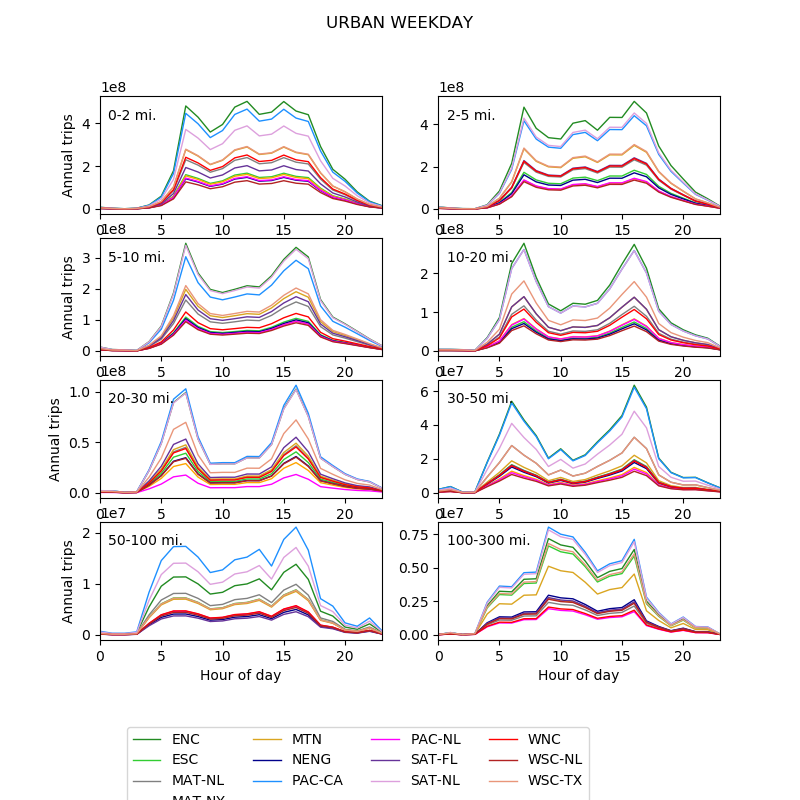

('ENC', 'URB', 'WEEKDAY')
('ESC', 'URB', 'WEEKDAY')
('MAT-NL', 'URB', 'WEEKDAY')
('MAT-NY', 'URB', 'WEEKDAY')
('MTN', 'URB', 'WEEKDAY')
('NENG', 'URB', 'WEEKDAY')
('PAC-CA', 'URB', 'WEEKDAY')
('PAC-NL', 'URB', 'WEEKDAY')
('SAT-FL', 'URB', 'WEEKDAY')
('SAT-NL', 'URB', 'WEEKDAY')
('WNC', 'URB', 'WEEKDAY')
('WSC-NL', 'URB', 'WEEKDAY')
('WSC-TX', 'URB', 'WEEKDAY')


In [65]:
regions = dist_hour_hists.index.levels[0]
len(regions)
colors=['forestgreen','limegreen','gray', 'orange', 'goldenrod','darkblue','dodgerblue','magenta','rebeccapurple','plum',
       'red','firebrick','darksalmon']
plot_dists_by_region(dist_hour_hists[range(24)].T,regions=regions,colors=colors, urbrur='URB',wktime='WEEKDAY')

In [66]:
hourly_profiles_agg.to_csv(data_dir+'\\binned_dists\\hourly_profiles_urb_rur.csv')
dist_hists.drop('REGION', axis=1).to_csv(data_dir+'\\binned_dists\\dist_hists_by_region.csv') #drop region to avoid confusion

In [67]:
hourly_profiles_agg

COUNTSRAW     COUNTSWTD   TRIPPCT
URBRURS WKTIME  MILEBIN STRTHOUR                                   
RUR     WEEKDAY 0-2     0               9.0  3.820271e+06  0.000624
                        1               1.0  2.720234e+04  0.000004
                        2               1.0  1.688021e+05  0.000028
                        3               3.0  4.933251e+06  0.000806
                        4              42.0  1.308867e+07  0.002138
                        5             184.0  5.076653e+07  0.008293
                        6             463.0  1.602533e+08  0.026179
                        7            1335.0  3.988634e+08  0.065157
                        8            1319.0  3.687985e+08  0.060246
                        9            1747.0  3.817226e+08  0.062357
                        10           2208.0  4.358206e+08  0.071195
                        11           2753.0  6.135356e+08  0.100226
                        12           2778.0  6.877927e+08  0.112356
                        13           2257.0  5.024851e+08  0.082085
                        14           2035.0  4.112836e+08  0.067186
                        15           2133.0  5.385738e+08  0.087980
                        16           1879.0  5.439644e+08  0.088861
                        17           1420.0  3.774200e+08  0.061655
                        18            786.0  2.706120e+08  0.044207
                        19            498.0  1.591644e+08  0.026001
                        20            332.0  1.178097e+08  0.019245
                        21            148.0  4.629810e+07  0.007563
                        22             62.0  2.216596e+07  0.003621
                        23             28.0  1.216335e+07  0.001987
                2-5     0              16.0  3.532641e+06  0.000589
                        1               7.0  5.388954e+06  0.000898
                        2               6.0  3.149173e+06  0.000525
                        3               7.0  1.427172e+06  0.000238
                        4              94.0  2.015450e+07  0.003358
                        5             250.0  4.885402e+07  0.008139
...                                     ...           ...       ...
URB     WEEKEND 50-100  17            110.0  6.286995e+07  0.079040
                        18            132.0  6.142208e+07  0.077220
                        19             99.0  4.602674e+07  0.057865
                        20             81.0  3.104815e+07  0.039034
                        21             56.0  1.984498e+07  0.024949
                        22             34.0  1.190867e+07  0.014972
                        23             11.0  4.015252e+06  0.005048
                100-300 0               6.0  1.788979e+06  0.003762
                        1               1.0  8.406507e+05  0.001768
                        3               4.0  2.322385e+06  0.004884
                        4              15.0  6.295021e+06  0.013239
                        5              21.0  1.325542e+07  0.027878
                        6              31.0  1.642368e+07  0.034541
                        7              60.0  3.817921e+07  0.080296
                        8              77.0  2.411937e+07  0.050726
                        9              79.0  2.916234e+07  0.061332
                        10             78.0  5.058215e+07  0.106381
                        11             81.0  3.316134e+07  0.069743
                        12             58.0  2.329421e+07  0.048991
                        13             81.0  3.585036e+07  0.075398
                        14             67.0  2.224357e+07  0.046781
                        15             75.0  3.922222e+07  0.082490
                        16             63.0  2.024485e+07  0.042578
                        17             61.0  2.963891e+07  0.062335
                        18             73.0  3.299337e+07  0.069390
                        19             44.0  3.023079e+07  0.063579
                      